In [1]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


In [2]:
# GLOBAL VARIABLES

input_shape = (100, 100, 1)

# Setup

In [5]:
# Project base path
%cd /content/drive/MyDrive/SEAIProject

!pip install import-ipynb
import import_ipynb

# Import other notebooks
import SignalGenerator

# Other imports
from google.colab.patches import cv2_imshow as imshow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model

/content/drive/MyDrive/SEAIProject


# Models

##Single Model

This model allows you to classify single images

The model is composed by a convolutional network that extracts a vector of 2048 features that go in input to two fullly connected layers of the same size. A single final sigmoidal neuron produces the score between 0 and 1 (signal absent, signal present)

In [ ]:
base_single = models.Sequential(name = "Base_single")
base_single.add(layers.Conv2D(32, (3, 3), activation='relu',
                input_shape = input_shape, name = "conv_1_1"))
base_single.add(layers.Conv2D(32, (3, 3), activation='relu', name = "conv_1_2"))
base_single.add(layers.MaxPooling2D((2, 2), name = "max_pooling_1"))
base_single.add(layers.Conv2D(32, (3, 3), activation='relu', name = "conv_2_1"))
base_single.add(layers.Conv2D(32, (3, 3), activation='relu', name = "conv_2_2"))
base_single.add(layers.MaxPooling2D((2, 2), name = "max_pooling_2"))
base_single.add(layers.Conv2D(64, (3, 3), activation='relu', name = "conv_3_1"))
base_single.add(layers.Conv2D(64, (3, 3), activation='relu', name = "conv_3_2"))
base_single.add(layers.Conv2D(64, (3, 3), activation='relu', name = "conv_3_3"))
base_single.add(layers.MaxPooling2D((2, 2), name = "max_pooling_3"))
base_single.add(layers.Conv2D(128, (3, 3), activation='relu', name = "conv_4_1"))
base_single.add(layers.Conv2D(128, (3, 3), activation='relu', name = "conv_4_2"))
base_single.add(layers.Flatten(name = "flatten"))

merged = layers.Dense(2048, activation='relu', name = "fc1")(base_single.layers[-1].output) 
merged = layers.Dropout(0.5, name = "drop1")(merged)
merged = layers.Dense(2048, activation='relu', name = "fc2")(merged)
merged = layers.Dropout(0.5, name = "drop2")(merged)
merged = layers.Dense(1, activation='sigmoid', name = "sig_out")(merged)

single_model = Model(base_single.input, merged, name = "SingleNet")

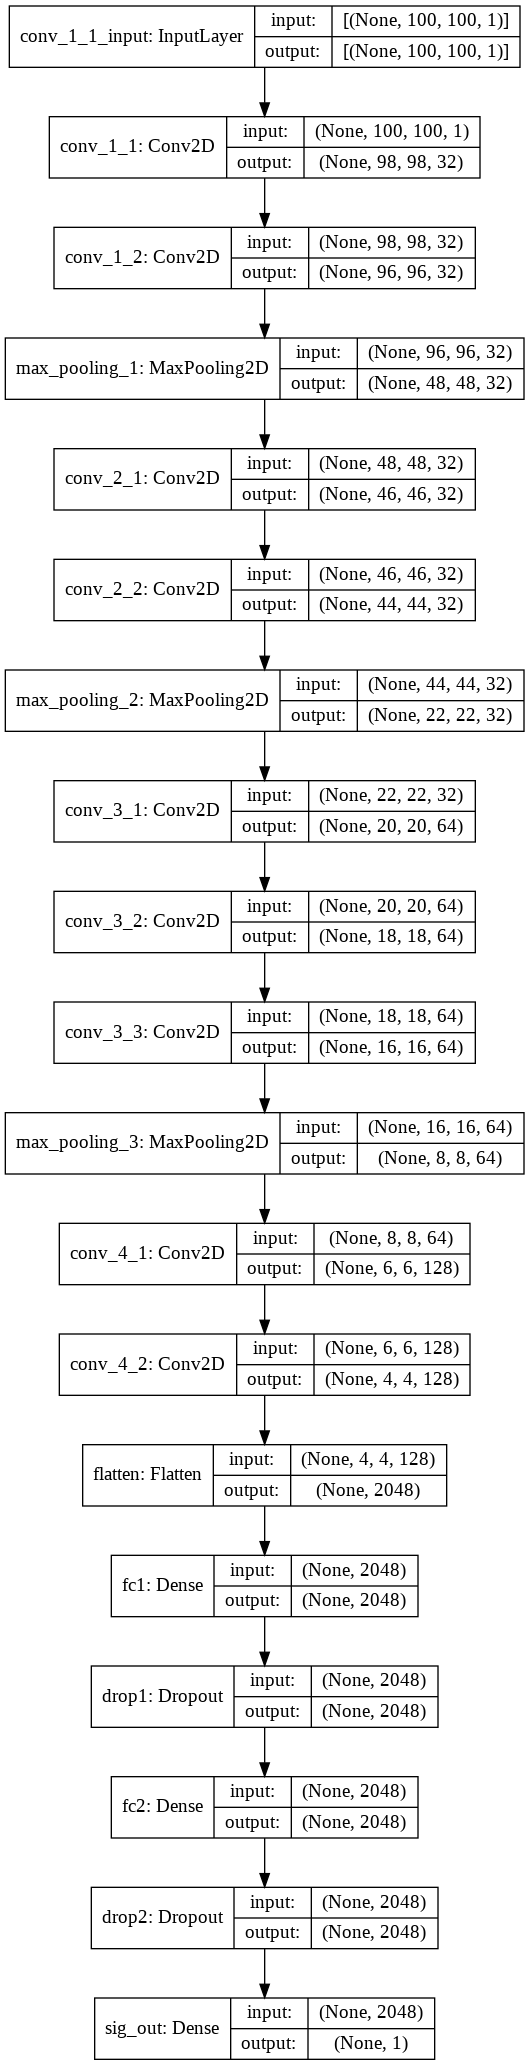

In [ ]:
tf.keras.utils.plot_model(single_model, show_shapes=True, show_layer_names=True)

##Siamese Model

This model is characterized by a Siamese network that takes in input two images, one with the signal and one without it. The network must identify where the signal is, whether it is in the left input (0) or in the right input (1)

The same CNN as the single network is used as the base model, the difference lies in the completely connected layers that take as input the features extracted from both inputs. A sigmoidal neuron is used to determine the score between 0 (signal on the left) and 1 (signal on the right)


In [ ]:
base_siamese = models.Sequential(name = "Base_siamese")
base_siamese.add(layers.Conv2D(32, (3, 3), activation='relu',
                  input_shape = input_shape, name = "conv_1_1"))
base_siamese.add(layers.Conv2D(32, (3, 3), activation='relu', name = "conv_1_2"))
base_siamese.add(layers.MaxPooling2D((2, 2), name = "max_pooling_1"))
base_siamese.add(layers.Conv2D(32, (3, 3), activation='relu', name = "conv_2_1"))
base_siamese.add(layers.Conv2D(32, (3, 3), activation='relu', name = "conv_2_2"))
base_siamese.add(layers.MaxPooling2D((2, 2), name = "max_pooling_2"))
base_siamese.add(layers.Conv2D(64, (3, 3), activation='relu', name = "conv_3_1"))
base_siamese.add(layers.Conv2D(64, (3, 3), activation='relu', name = "conv_3_2"))
base_siamese.add(layers.Conv2D(64, (3, 3), activation='relu', name = "conv_3_3"))
base_siamese.add(layers.MaxPooling2D((2, 2), name = "max_pooling_3"))
base_siamese.add(layers.Conv2D(128, (3, 3), activation='relu', name = "conv_4_1"))
base_siamese.add(layers.Conv2D(128, (3, 3), activation='relu', name = "conv_4_2"))
base_siamese.add(layers.Flatten(name = "flatten"))

left_input = keras.Input(input_shape, name = "left_input")
right_input = keras.Input(input_shape, name = "right_input")

encoded_l = base_siamese(left_input)
encoded_r = base_siamese(right_input)

merged = layers.concatenate([encoded_l, encoded_r], name="concat_layer")
merged = layers.Dense(4096, activation='relu', name = "fc1")(merged) 
merged = layers.Dropout(0.5, name = "drop1")(merged)
merged = layers.Dense(4096, activation='relu', name = "fc2")(merged)
merged = layers.Dropout(0.5, name = "drop2")(merged)
merged = layers.Dense(1, activation='sigmoid', name = "sig_out")(merged)

siamese_model = Model([left_input, right_input], merged, name = "SiameseTAFCNet")

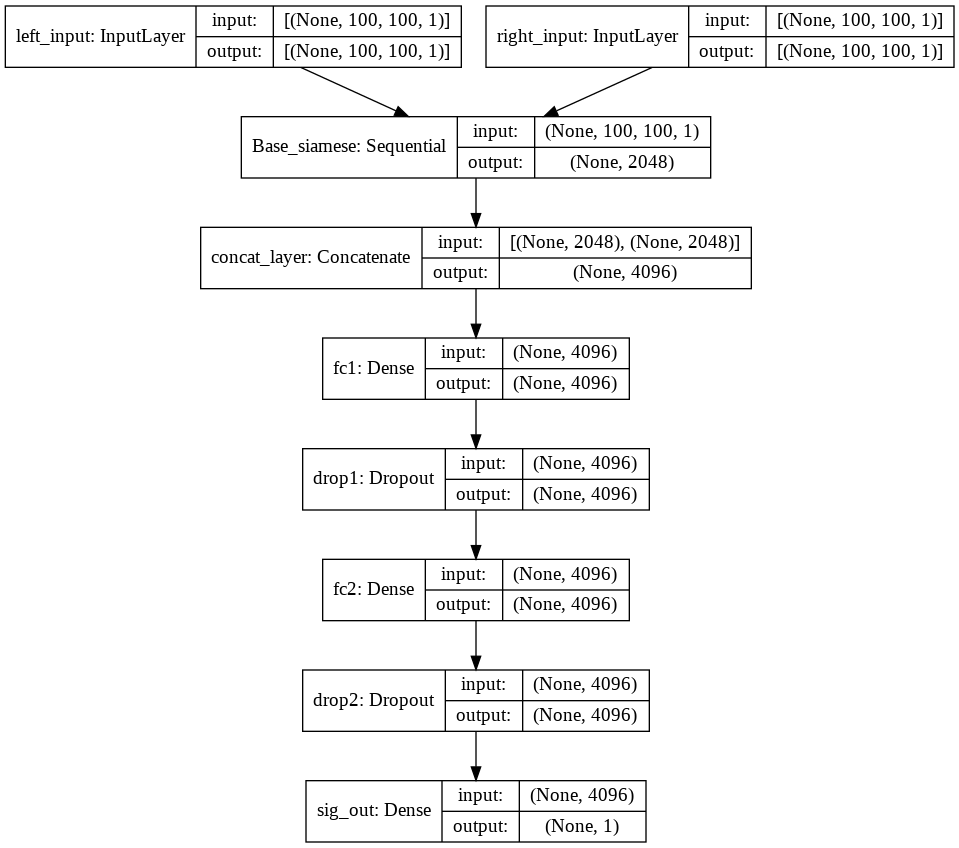

In [ ]:
tf.keras.utils.plot_model(siamese_model, show_shapes=True, show_layer_names=True)

# Comparison

##Setup

This function allows you to generate the batches used during training. These are randomly generated. In the single case the batch is composed of single images 50% with signal and 50% without. In the case of the alternative choices, the batch is composed of two images, one with the signal and one without, where the image with the signal is randomly to the right or to the left.

In [6]:
from tqdm.notebook import tqdm
import numpy as np   

class Training_Signal_Generator(keras.utils.Sequence):
  '''
  Custom data generator to be used by keras model utilities to retreive and 
  preprocess batches of data
   _
  |_| batch --> []-[]-[]-[]... < [] --> [left_img][right_img]
  |_| label --> l1-l2-l3-l4... --> if sig on left --> lab = 0 otherwise 1

  '''
  
  def __init__(
      self, 
      batch_size = 32, 
      batches_per_epoch = 1,
      single = False
  ):
      self.batch_size = batch_size
      self.batches_per_epoch = batches_per_epoch
      self.single = single

  def __len__(self):
      # Denotes the number of batches per epoch
      return self.batches_per_epoch

  def __getitem__(self, index):
      X, y = self.__get_data()
      return X, y

  def generate_batch(self):

    return self.__getitem__(0)

  def __get_data(self):

    batch_left = []
    batch_right = []
    labels = []
    batch = []
    
    for _ in range(self.batch_size):

      if self.single:

        # Single input
        
        bv=np.random.uniform(0.2,0.8)
        if np.random.rand() > 0.5:
          # if sig present --> lab = 1
          batch.append(SignalGenerator.generate_img_signal(apply_signal=True, apply_noise=True, signal_transparency= np.random.uniform(0.005,0.05), signal_sd = np.random.uniform(5,25), noise_sd=np.random.uniform(0.01,0.2), background_value = bv))   
          labels.append(1)
        else:
          # if sig absent --> lab = 0
          batch.append(SignalGenerator.generate_img_signal(apply_signal=False, apply_noise=True, noise_sd=np.random.uniform(0.01,0.2),  background_value = bv) )
          labels.append(0)

      else:

        # Double input for siamese 

        bv=np.random.uniform(0.2,0.8) # same background as described in the paper (Abbey et al.)

        img_signal = SignalGenerator.generate_img_signal(apply_signal=True, apply_noise=True, signal_transparency= np.random.uniform(0.005,0.05), signal_sd = np.random.uniform(5,30), noise_sd=np.random.uniform(0.01,0.2), background_value = bv)
        img_no_signal = SignalGenerator.generate_img_signal(apply_signal=False, apply_noise=True, noise_sd=np.random.uniform(0.01,0.2),  background_value = bv) 

        if np.random.rand() > 0.5:
          # if sig on left --> lab = 0
          batch_left.append(img_signal)   
          batch_right.append(img_no_signal)
          labels.append(0)
        else:
          # if sig on right --> lab = 1
          batch_left.append(img_no_signal)   
          batch_right.append(img_signal)  
          labels.append(1)
        
        batch = [np.array(batch_left),np.array(batch_right)]

    if self.single:
      batch = np.array(batch)

    return batch, np.array(labels)

Used to print progressive plots to visualize accuracy during traning

In [ ]:
!pip install jupyterplot
from jupyterplot import ProgressPlot
import numpy as np

class PlotCallback(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.pp = ProgressPlot(line_names=["Training"], x_iterator=False, plot_names=["Accuracy","Loss"], x_label="Epoch", y_lim=[0,1])

  def on_train_end(self, logs=None):
    self.pp.finalize()

  def on_epoch_end(self, epoch, logs=None):
    self.pp.update(epoch, [[logs["accuracy"]], [logs["loss"]]])

## Batch Example

Correctly prints the batches to visualize their composition

In [7]:
def print_batch(batch, labels, single):
  if single:
    for img, label in zip(batch, labels):
      print("Label: " + str(label))
      imshow(img*255)
  else:
    for sx, dx, label in zip(batch[0], batch[1], labels):
      print("Label: " + str(label))
      imshow(sx*255)
      imshow(dx*255)

Label: 0


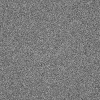

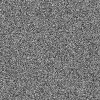

Label: 1


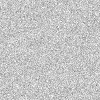

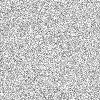

Label: 0


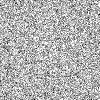

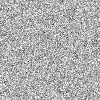

Label: 0


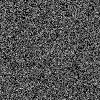

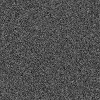

Label: 1


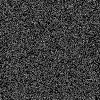

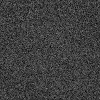

Label: 0


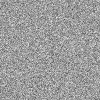

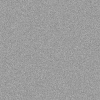

Label: 1


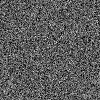

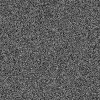

Label: 0


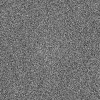

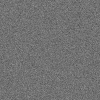

Label: 0


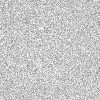

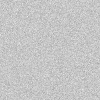

Label: 1


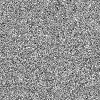

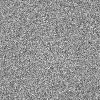

In [ ]:
# Two alternatives batch
test = Training_Signal_Generator(batch_size=10,single=False)
batch = test.generate_batch()
print_batch(batch[0], batch[1], single=False)

Label: 0


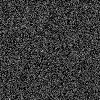

Label: 0


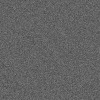

Label: 1


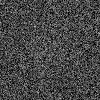

Label: 1


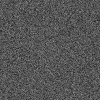

Label: 0


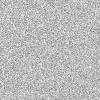

Label: 0


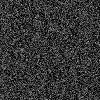

Label: 0


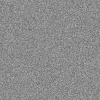

Label: 1


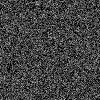

Label: 0


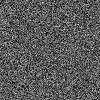

Label: 1


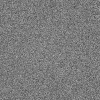

In [8]:
# Single batch

test = Training_Signal_Generator(batch_size=10,single=True)
batch = test.generate_batch()
print_batch(batch[0], batch[1], single=True)

##Training

Training of the two models for 50 epochs each to allow comparison. It is not necessary to use a validation set as the images are synthetic and the models cannot overfit. 





### SINGLE

Training of the single image model. Parameters were chosen heuristically.

In [ ]:
# Single
training_generator = Training_Signal_Generator(batch_size=32, batches_per_epoch=128, single=True)
single_model.compile(loss='binary_crossentropy', optimizer= keras.optimizers.Adam(1e-5), metrics=['accuracy'])
MAX_EPOCHS = 50
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

history = single_model.fit(  training_generator, 
                              epochs=MAX_EPOCHS, 
                              workers=1, 
                              use_multiprocessing=False, 
                              callbacks=[PlotCallback()])

Epoch 1/50
128/128 [==============================] - 38s 36ms/step - loss: 0.6932 - accuracy: 0.4846
Epoch 2/50
128/128 [==============================] - 5s 36ms/step - loss: 0.6932 - accuracy: 0.5002
Epoch 3/50
128/128 [==============================] - 5s 36ms/step - loss: 0.6929 - accuracy: 0.5065
Epoch 4/50
128/128 [==============================] - 4s 35ms/step - loss: 0.6936 - accuracy: 0.4762
Epoch 5/50
128/128 [==============================] - 5s 35ms/step - loss: 0.6931 - accuracy: 0.4967
Epoch 6/50
128/128 [==============================] - 5s 36ms/step - loss: 0.6931 - accuracy: 0.5091
Epoch 7/50
128/128 [==============================] - 5s 35ms/step - loss: 0.6930 - accuracy: 0.5135
Epoch 8/50
128/128 [==============================] - 5s 36ms/step - loss: 0.6930 - accuracy: 0.5033
Epoch 9/50
128/128 [==============================] - 5s 35ms/step - loss: 0.6930 - accuracy: 0.5002
Epoch 10/50
128/128 [==============================] - 5s 36ms/step - loss: 0.6927 - accur

### SIAMESE

Training of the siamese model on the two alternative choice problem. Parameters were chosen heuristically.

In [ ]:
# Siamese
training_generator = Training_Signal_Generator(batch_size=32, batches_per_epoch=128)
siamese_model.compile(loss='binary_crossentropy', optimizer= keras.optimizers.Adam(1e-5), metrics=['accuracy'])
MAX_EPOCHS = 50
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

history = siamese_model.fit(  training_generator, 
                              epochs=MAX_EPOCHS, 
                              workers=1, 
                              use_multiprocessing=False, 
                              callbacks=[PlotCallback()])

Epoch 1/50
128/128 [==============================] - 12s 85ms/step - loss: 0.6932 - accuracy: 0.5035
Epoch 2/50
128/128 [==============================] - 11s 84ms/step - loss: 0.6923 - accuracy: 0.5292
Epoch 3/50
128/128 [==============================] - 11s 84ms/step - loss: 0.6905 - accuracy: 0.5653
Epoch 4/50
128/128 [==============================] - 11s 84ms/step - loss: 0.6667 - accuracy: 0.6366
Epoch 5/50
128/128 [==============================] - 11s 84ms/step - loss: 0.4857 - accuracy: 0.7853
Epoch 6/50
128/128 [==============================] - 11s 85ms/step - loss: 0.3181 - accuracy: 0.8694
Epoch 7/50
128/128 [==============================] - 11s 84ms/step - loss: 0.2605 - accuracy: 0.8978
Epoch 8/50
128/128 [==============================] - 11s 85ms/step - loss: 0.1707 - accuracy: 0.9352
Epoch 9/50
128/128 [==============================] - 11s 85ms/step - loss: 0.1992 - accuracy: 0.9201
Epoch 10/50
128/128 [==============================] - 11s 84ms/step - loss: 0.163

## Save Models

In [ ]:
siamese_model.save("Models/Siamese")
single_model.save("Models/Single")

## Load Models

In [ ]:
siamese_model = keras.models.load_model('Models/Siamese')
single_model = keras.models.load_model('Models/Single')

# Test

Comparison between the various models

## Utils

Utility function to plot the confusion matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Single Test

Create a synthetic training set consisting of 10 000 images to check the quality of the single input model

In [ ]:
test_generator = Training_Signal_Generator(batch_size=10000, single=True)
testset = test_generator.generate_batch()

Model predictions

In [ ]:
single_preds = single_model.predict(testset[0], batch_size = 100)

Confusion matrix

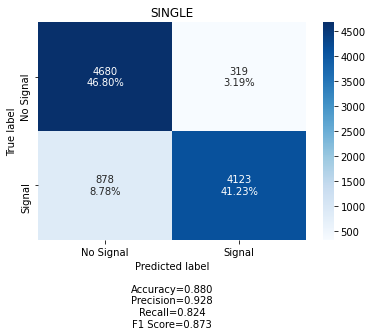

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(testset[1], [i>0.5 for i in single_preds])
make_confusion_matrix(cf_matrix, categories=["No Signal", "Signal"], title="SINGLE")

Roc curve of the model. Note the AUC value of 0.952, it is the same as the accuracy of the model for the two alternative forced choice problem, confirming the theory.

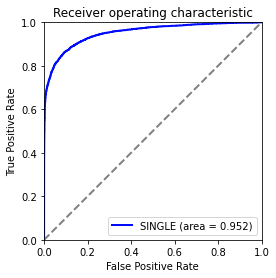

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(testset[1], single_preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=plt.cm.winter(1-roc_auc),lw=2, label= "SINGLE" + ' (area = %0.3f)' % roc_auc)
    
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

The tROC can be easily obtained from the standard ROC curve considering that on the ordinate axis there must be TPR * TNR instead of only TPR and that the TNR can be easily obtaind complementing the vector of the FPR

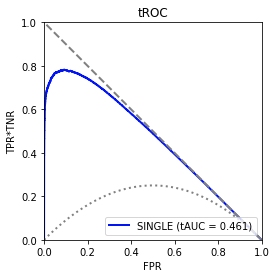

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(testset[1], single_preds)
tnr = 1 - fpr
tpr_per_tnr = tpr*tnr
roc_auc = auc(fpr, tpr_per_tnr)
plt.plot(fpr, tpr_per_tnr, color=plt.cm.winter(1-roc_auc*2),lw=2, label= "SINGLE" + ' (tAUC = %0.3f)' % roc_auc)

# Optimal Classifier
plt.plot([1, 0], [0, 1], color='gray', lw=2, linestyle='--')
# Random Classifier
x = np.arange(0., 1., 0.01)
plt.plot(x, x*(1-x), color='gray', lw=2, linestyle=':')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('FPR')
plt.ylabel('TPR*TNR')
plt.title('tROC')
plt.legend(loc="lower right")

plt.show()

## Double Imput Comparison

Creation of a synthetic test set for the two forced choice problem, consisting of 10 000 pairs of images

In [ ]:
from tqdm.notebook import tqdm
import gc
import numpy as np

size = 1000

final_batch_left = []
final_batch_right = []
final_labels = []
first = True

for _ in tqdm(range(10)):
  # Is more efficient in this way
  # python have problems with small appends to big lists
  # so I create 10 lists and then merge at the end
  batch_left = []
  batch_right = []
  labels = []
  batch = []
  gc.collect()

  for _ in range(size):

    # Double input for siamese 

    bv=np.random.uniform(0.2,0.8)
    img_signal = SignalGenerator.generate_img_signal(apply_signal=True, apply_noise=True, signal_transparency= np.random.uniform(0.005,0.05), signal_sd = np.random.uniform(5,30), noise_sd=np.random.uniform(0.01,0.2), background_value = bv)
    img_no_signal = SignalGenerator.generate_img_signal(apply_signal=False, apply_noise=True, noise_sd=np.random.uniform(0.01,0.2),  background_value = bv) 

    if np.random.rand() > 0.5:
      # if sig on left --> lab = 0
      batch_left.append(img_signal)   
      batch_right.append(img_no_signal)
      labels.append(0)
    else:
      # if sig on right --> lab = 1
      batch_left.append(img_no_signal)   
      batch_right.append(img_signal)  
      labels.append(1)

  if first:
    first = False
    final_batch_left = batch_left 
    final_batch_right = batch_right
    final_labels = labels
  else:
    final_batch_left.extend(batch_left)
    final_batch_right.extend(batch_right)
    final_labels.extend(labels)
    
testset = [[np.array(final_batch_left), np.array(final_batch_right)], final_labels]

Prediction of the Siamese network

In [ ]:
siamese_preds = siamese_model.predict(testset[0], batch_size = 100)

Below are the predictions given by the single model to the problem of two alternative forced choices. To allow a comparison with the siamese model using ROC and tROC, the classification confidence for the single input model is calculated as the relative difference between the signal image score and the empty image score

In [ ]:
from tqdm.notebook import tqdm

# Comparison between two scores

single_preds = []

left_preds = single_model.predict(testset[0][0], batch_size = 100)
right_preds = single_model.predict(testset[0][1], batch_size = 100)

for left, right in zip(left_preds, right_preds):

  if left>right:
    # signal left
    single_preds.append(0.5 - (left-right)*0.5)
  else:
    # signal right
    single_preds.append(0.5 + (right - left)*0.5)

Comparison of the confusion matrix between the two models.
The Siamese model as expected reaches a higher level of accuracy since it can directly compare the features extracted from the two images instead of the scores as for the single model. Note that the accuracy value of the single model in the case of the two alternative forced choice problem is equal to the AUC calculated for the classification problem of the single images.

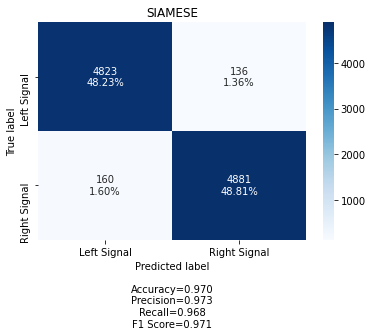

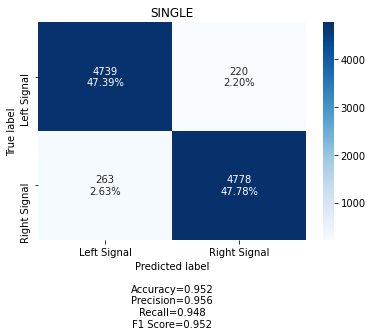

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(testset[1], [i>0.5 for i in siamese_preds])
make_confusion_matrix(cf_matrix, categories=["Left Signal", "Right Signal"], title="SIAMESE")

cf_matrix = confusion_matrix(testset[1], [i>0.5 for i in single_preds])
make_confusion_matrix(cf_matrix, categories=["Left Signal", "Right Signal"], title="SINGLE")

Comparison between the roc curves of the two models. As expected, the AUC of the Siamese model is better than that of the single input model.

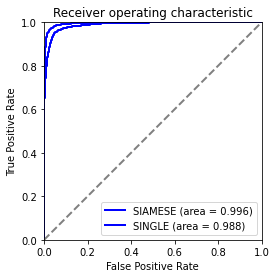

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(testset[1], siamese_preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=plt.cm.winter(1-roc_auc),lw=2, label= "SIAMESE" + ' (area = %0.3f)' % roc_auc)

fpr, tpr, _ = roc_curve(testset[1], single_preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=plt.cm.winter(1-roc_auc),lw=2, label= "SINGLE" + ' (area = %0.3f)' % roc_auc)
    
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

The comparison between the tROCs of the two models confirms the results.

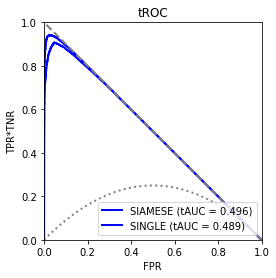

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(testset[1], siamese_preds)
tnr = 1 - fpr
tpr_per_tnr = tpr*tnr
roc_auc = auc(fpr, tpr_per_tnr)
plt.plot(fpr, tpr_per_tnr, color=plt.cm.winter(1-roc_auc*2),lw=2, label= "SIAMESE" + ' (tAUC = %0.3f)' % roc_auc)

fpr, tpr, _ = roc_curve(testset[1], single_preds)
tnr = 1 - fpr
tpr_per_tnr = tpr*tnr
roc_auc = auc(fpr, tpr_per_tnr)
plt.plot(fpr, tpr_per_tnr, color=plt.cm.winter(1-roc_auc*2),lw=2, label= "SINGLE" + ' (tAUC = %0.3f)' % roc_auc)

# Optimal Classifier
plt.plot([1, 0], [0, 1], color='gray', lw=2, linestyle='--')
# Random Classifier
x = np.arange(0., 1., 0.01)
plt.plot(x, x*(1-x), color='gray', lw=2, linestyle=':')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('FPR')
plt.ylabel('TPR*TNR')
plt.title('tROC')
plt.legend(loc="lower right")

plt.show()